# **Sentiment Index Generation: Llama**

## **What is an Large Language Model (LLM)?**

An **LLM** is a type of Artificial Intelligence system that’s trained to understand and generate human language.

* **Large** refers to the huge amount of data and parameters it’s trained on (often billions or trillions).

* **Language Model** means it predicts and generates text based on context.

* Examples: **GPT-5, Claude, Gemini, LLaMA,** etc.

* Used for: chatbots, translation, writing, coding, summarization, **classification**, analysis, and more.

## **Main Features of LLMs**

* **Enormous volume / scale of training data**: These models are trained on immense amounts of textual data from the Internet, which include a wide range of topics, writing styles, and languages. This vast dataset provides exposure to diverse linguistic patterns, vocabulary usage, and syntactic structures."

* **Self-supervised learning objective:** During training, these models learn to predict the next word in a sequence of text (an autoregressive objective). This task inherently requires the model to understand the context of preceding words, which encourages it to capture semantic relationships, syntactic rules, and pragmatic nuances present in the text.

* **Transformer architecture:** LLMs like ChatGPT are based on transformer architectures, which excel at capturing long-term dependencies in data. The self-attention mechanism in transformers allows the model to assess the relevance of different words in a sentence, enabling it to understand and generate coherent responses based on the provided context.

* **Fine-tuning:** After pre-training on a large corpus of texts, these models can be refined for specific tasks or domains using labeled data. Fine-tuning adapts the general linguistic knowledge acquired during pre-training to perform more specialized tasks, such as answering questions or engaging in dialogue."

## **Transformer Architecture**

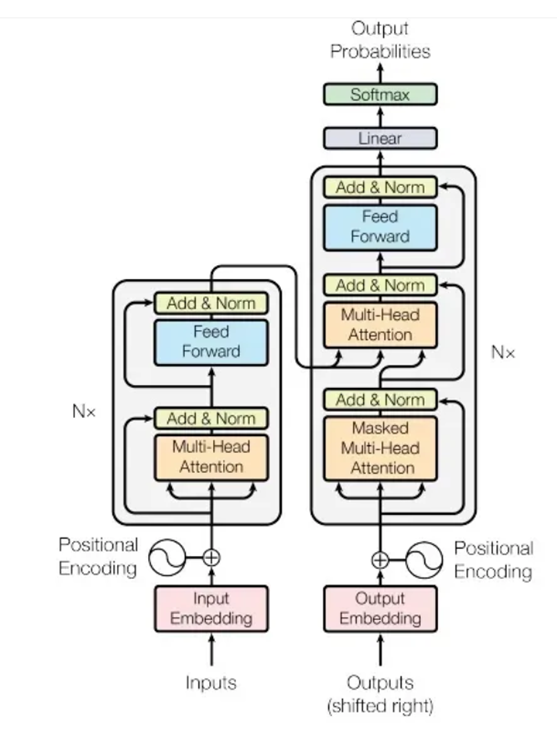

# **What is LLama?**

**LLaMA** stands for Large Language Model Meta AI — it’s a family of open-weight Large Language Models developed by **Meta** (Facebook’s parent company). **LLaMA** — just like GPT or Claude — is designed to understand and generate human-like text.
It’s used for chatbots, coding assistants, translation, **classification**, summarization, and more. **LLaMA** helped democratize AI research — developers and researchers can experiment, fine-tune, and deploy it freely. It powers many open-source chatbots, like Vicuna, Mistral-based blends, and other community-driven models.

* First released in February 2023 (**LLaMA 1**).

* **LLaMA 2 (July 2023)** — open for commercial use.

* **LLaMA 3 (2024)** — more powerful, multilingual, and better reasoning.

# **All Installations**

In [1]:
%pip install transformers datasets peft accelerate evaluate torch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00


In [2]:
%pip install python-dotenv

In [3]:
%pip install plotly

In [4]:
import os
import platform

def data_download(file_to_download, gdrive_code, OS, uncompress = True):
  if not os.path.exists(file_to_download):
    os.system('gdown --id "'+gdrive_code+'" --output '+file_to_download)
    if OS == "Linux" and uncompress:
        os.system('unzip -o -n "./'+file_to_download+'" -d "./"')
    return True
  else:
    return None

OS = platform.system()

out = data_download("./Sentiment_Dataset.zip", "1OEQpkzN6HMcZc3yPg8G0ahvh6lOCMlIR", OS)

# **All Imports**

In [5]:
#General
import timeit
import torch
import random
import calendar
import numpy as np
import pandas as pd
from dotenv import load_dotenv
import plotly.express as px
import shutil

# LLMs
import evaluate
from datasets import Dataset
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from peft import LoraConfig, get_peft_model

# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# **All Globals**

In [10]:
seed = 42
dataset_limit = 4000
sentiment_index_limit = 130
n_tweets_per_day = 400
n_epochs = 10
moving_average_window = 7
llm_model_parameters_number = '1B'                # number of billion parameters of the LLM mode, 1B is the smaller llama3.2 1 billion of parameters
#model_name = f"meta-llama/Llama-3.2-{llm_model_parameters_number}-Instruct"
model_name = f"meta-llama/Llama-3.2-{llm_model_parameters_number}"
dataset_path = "./Sentiment_Dataset/"
chart_from_local = True

# **Initializations**

In [7]:
os.environ["WANDB_MODE"] = "disabled"

start_global_time = timeit.default_timer()

!mv "{dataset_path}.env" ./
random.seed(seed)
np.random.seed(seed)

load_dotenv()

True

# **Functions Definition**

In [ ]:
def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

def df_predictions(df, tokenized_df, trainer, label_mapping):
    predictions = trainer.predict(tokenized_df)
    predicted_labels = predictions.predictions.argmax(-1)
    label_mapping = np.load("labels_mapping.npy", allow_pickle=True).item()
    reverse_label_mapping = {v: k for k, v in label_mapping.items()}
    predicted_sentiment = [reverse_label_mapping[label] for label in predicted_labels]
    df['predicted_sentiment'] = predicted_sentiment
    return df

def month_sort_key(month_dir):
    month_name = os.path.basename(month_dir).split('_')[0]
    try:
        return list(calendar.month_name).index(month_name.capitalize())
    except ValueError:
        return 0

# **Dataset Reading**

In [ ]:
irony_df = pd.read_csv("./Sentiment_Dataset/irony_dataset.txt", header=None).rename(columns={0: 'text'})["text"].to_frame()

In [ ]:
df = pd.read_csv("./Sentiment_Dataset/training_set.csv", sep = ";")
df = df[["text", "pol"]].dropna()         # select the columns interesting for us and drop rows with NaN

In [ ]:
if dataset_limit is not None:
    df = df.sample(dataset_limit).reset_index(drop=True)

In [ ]:
print("Numnber of data-points:", len(df))

Numnber of data-points: 4000


In [ ]:
df.head()

,text,pol
0,Arbasina/Giavazzi sul Corriere a proposito del...,0.0
1,il trading è un amp azienda ecco come risparmi...,1.0
2,"RT TAG mi hanno unfollowato in massa, mortacci...",2.0
3,modalità prezzi e biglietti per la gara al man...,0.0
4,donnastef shop t shirt gonna borsa spedizione ...,0.0


1: 'Positive', 2: 'Negative', 0: 'Neutral'

In [ ]:
print("Number of classes", df["pol"].nunique())
print("Types of classes", df["pol"].unique())

Number of classes 3
Types of classes [0. 1. 2.]


# **Dataset Recoding**

In [ ]:
df['pol'] = df['pol'].map({1: 'Positive', 2: 'Negative', 0: 'Neutral'})
df = df.rename(columns={'pol': 'label'})

In [ ]:
df.head()

,text,label
0,Arbasina/Giavazzi sul Corriere a proposito del...,Neutral
1,il trading è un amp azienda ecco come risparmi...,Positive
2,"RT TAG mi hanno unfollowato in massa, mortacci...",Negative
3,modalità prezzi e biglietti per la gara al man...,Neutral
4,donnastef shop t shirt gonna borsa spedizione ...,Neutral


# **Label Conversion**

In [ ]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
np.save("labels_mapping.npy", label_mapping)
print("Label mapping:", label_mapping)

Label mapping: {'Negative': np.int64(0), 'Neutral': np.int64(1), 'Positive': np.int64(2)}


# **Train-Test Split**

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# **Dataset Conversion for Transformers**

In [ ]:
irony_dataset = Dataset.from_pandas(irony_df)
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
unique_labels = train_dataset.unique('label')
num_labels = len(unique_labels)
print("Number of Labels withing the Training Set:", len(unique_labels))

Number of Labels withing the Training Set: 3


In [ ]:
train_dataset

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 3200
})

In [ ]:
test_dataset

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 800
})

# **Tokenization and Padding**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
tokenized_irony = irony_dataset.map(tokenize_function, batched=True)
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/71 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

## **Load the LLM Model**

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    torch_dtype=torch.bfloat16,
    device_map="auto"                           # auto: for 1 GPU, and balanced_low_0 for multi-gput
)

`torch_dtype` is deprecated! Use `dtype` instead!
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **Definition of QLora**

In [ ]:
# === 7. Applica LoRA (fine-tuning efficiente) ===
peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(model, peft_config)

 # **Metrics Definition**

In [ ]:
accuracy = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.argmax(-1)
    return accuracy.compute(predictions=preds, references=labels)

# **Training Parameters Definition**

In [ ]:
training_args = TrainingArguments(
    output_dir="./llama3_finetuned",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=n_epochs,
    learning_rate=2e-5,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    report_to=[]  # Disactivate the W&B
)

# **Training Model Definition**

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipykernel_3840/3389762461.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The model is already on multiple devices. Skipping the move to device specified in `args`.


In [ ]:
#irony_df = df_predictions(irony_df, tokenized_irony, trainer, label_mapping)

In [ ]:
#irony_df

In [ ]:
'''
negative_count = irony_df[irony_df['predicted_sentiment'] == 'Negative'].shape[0]
total_count = irony_df.shape[0]
percentage_negative = (negative_count / total_count) * 100

print(f"Percentage of negative sentiments detected in irony_df after training: {percentage_negative:.2f}%")
'''

'\nnegative_count = irony_df[irony_df[\'predicted_sentiment\'] == \'Negative\'].shape[0]\ntotal_count = irony_df.shape[0]\npercentage_negative = (negative_count / total_count) * 100\n\nprint(f"Percentage of negative sentiments detected in irony_df after training: {percentage_negative:.2f}%")\n'

# **Model Training**

In [ ]:
start_time = timeit.default_timer()
trainer.train()
print("Elapsed Training Time: ", timeit.default_timer() - start_time)

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 128001}.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.001400,0.957807,0.667500
2,1.318800,1.105766,0.688750
3,1.411100,1.445721,0.702500
4,0.846400,1.516287,0.690000
5,0.932300,1.720971,0.700000
6,0.507800,1.957135,0.690000
7,0.575000,2.072435,0.691250
8,0.364700,2.259529,0.678750
9,0.119800,2.260540,0.682500
10,0.154600,2.294216,0.686250


Elapsed Training Time:  1055.635041049


# **Model Evaluation**

In [ ]:
results = trainer.evaluate()
print(f"\n✅ Accuracy sul test set: {results['eval_accuracy']:.4f}")


✅ Accuracy sul test set: 0.6675


# **Model Testing on Irony Dataset**

In [ ]:
irony_df = df_predictions(irony_df, tokenized_irony, trainer, label_mapping)

In [ ]:
irony_df

,text,predicted_sentiment
0,"Oh, che meraviglia, ancora una volta il treno ...",Negative
1,La mia giornata è stata così fantastica che st...,Positive
2,Sono così grato al mio capo per avermi assegna...,Neutral
3,"Wow, sono così felice che il mio vicino abbia ...",Positive
4,Adoro quando il mio computer decide di bloccar...,Negative
...,...,...
66,Finalmente ho trovato il tempo per riposarmi e...,Positive
67,La mia squadra del cuore ha appena pareggiato ...,Positive
68,"Oh, fantastico, ho dimenticato il mio portafog...",Positive
69,Sono così fortunato ad avere una sveglia così ...,Negative


In [ ]:
negative_count = irony_df[irony_df['predicted_sentiment'] == 'Negative'].shape[0]
total_count = irony_df.shape[0]
percentage_negative = (negative_count / total_count) * 100

print(f"Percentage of negative sentiments detected in irony_df after training: {percentage_negative:.2f}%")

Percentage of negative sentiments detected in irony_df after training: 18.31%


# **Sentiment Index Creation**

## **Tweets Production Set Reading**

In [ ]:
start_time = timeit.default_timer()
all_dataframes = []
directory_path = "./Sentiment_Dataset/2020_index_tweets_set/"
month_directories = [os.path.join(directory_path, d) for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]
month_directories.sort(key=month_sort_key) # Sort the directories chronologically

for month_dir in month_directories:
    print("Month File: ", month_dir)
    csv_files = [f for f in os.listdir(month_dir) if f.endswith('.csv')]
    # Sort csv files by date in filename
    csv_files.sort(key=lambda x: x.split('.')[0])
    for file_name in csv_files:
        print("Day File: ", file_name)
        file_path = os.path.join(month_dir, file_name)
        try:
            df = pd.read_csv(file_path, encoding='utf-8', nrows = n_tweets_per_day, sep = ';')
        except UnicodeDecodeError:
            df = pd.read_csv(file_path, encoding='latin1', nrows = n_tweets_per_day, sep = ';')
        all_dataframes.append((file_name.split('.')[0], df["testo"]))
print("Elapsed Tweets Reading time: ", timeit.default_timer() - start_time)

Month File:  ./Sentiment_Dataset/2020_index_tweets_set/jan_tweets_social_mood
Day File:  2020-01-01.csv
Day File:  2020-01-02.csv
Day File:  2020-01-03.csv
Day File:  2020-01-04.csv
Day File:  2020-01-05.csv
Day File:  2020-01-06.csv
Day File:  2020-01-07.csv
Day File:  2020-01-08.csv
Day File:  2020-01-09.csv
Day File:  2020-01-10.csv
Day File:  2020-01-11.csv
Day File:  2020-01-12.csv
Day File:  2020-01-13.csv
Day File:  2020-01-14.csv
Day File:  2020-01-15.csv
Day File:  2020-01-16.csv
Day File:  2020-01-17.csv
Day File:  2020-01-18.csv
Day File:  2020-01-19.csv
Day File:  2020-01-20.csv
Day File:  2020-01-21.csv
Day File:  2020-01-22.csv
Day File:  2020-01-23.csv
Day File:  2020-01-24.csv
Day File:  2020-01-25.csv
Day File:  2020-01-26.csv
Day File:  2020-01-27.csv
Day File:  2020-01-28.csv
Day File:  2020-01-29.csv
Day File:  2020-01-30.csv
Day File:  2020-01-31.csv
Month File:  ./Sentiment_Dataset/2020_index_tweets_set/february_tweets_social_mood
Day File:  2020-02-01.csv
Day Fil

In [ ]:
all_dataframes[0]

('2020-01-01',
 0      per la cronaca canova fu uno dei primi monumen...
 1      l opera d arte del giorno antonio canova amore...
 2      rt borghi claudio iniziare l anno con uno che ...
 3      tutta salute approda in seconda serata per ini...
 4      un anno di lavoro se permetti lo auguro io a t...
                              ...                        
 395    aiuto aiuto adozione urgente urgente rt urgent...
 396    rt sofiacalliano nasce il bebè e dopo otto ann...
 397    araloire camillopeppino snaiderbaura sì aument...
 398    alfonsobonafede ferraresi v giorgis piccolo bi...
 399    iniziato alla grande e senza farmi mancare nul...
 Name: testo, Length: 400, dtype: object)

## **Sentiment Index Predictions**

In [ ]:
start_time = timeit.default_timer()
daily_sentiment_counts = []

i = 0
for date, series in all_dataframes:
    print(f"Computing day {date}")
    df = series.to_frame(name='text')
    dataset = Dataset.from_pandas(df)
    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    predictions = trainer.predict(tokenized_dataset)
    predicted_labels = predictions.predictions.argmax(-1)
    label_mapping = np.load("labels_mapping.npy", allow_pickle=True).item()
    reverse_label_mapping = {v: k for k, v in label_mapping.items()}
    predicted_sentiment = [reverse_label_mapping[label] for label in predicted_labels]
    positive_count = predicted_sentiment.count('Positive')
    negative_count = predicted_sentiment.count('Negative')
    neutral_count = predicted_sentiment.count('Neutral')
    daily_sentiment_counts.append({'date': date, 'positive': positive_count, 'negative': negative_count, "sentiment_index": (positive_count-negative_count)/(positive_count+neutral_count+negative_count)})
    i += 1
    if i>=sentiment_index_limit and sentiment_index_limit is not None:
      break

sentiment_counts_df = pd.DataFrame(daily_sentiment_counts)
#display(sentiment_counts_df)
print("Elapsed Sentimet Index Predictions time: ", timeit.default_timer() - start_time)

Computing day 2020-01-01


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-02


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-03


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-04


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-05


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-06


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-07


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-08


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-09


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-10


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-11


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-12


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-13


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-14


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-15


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-16


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-17


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-18


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-19


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-20


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-21


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-22


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-23


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-24


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-25


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-26


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-27


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-28


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-29


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-30


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-01-31


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-01


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-02


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-03


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-04


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-05


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-06


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-07


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-08


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-09


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-10


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-11


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-12


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-13


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-14


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-15


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-16


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-17


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-18


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-19


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-20


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-21


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-22


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-23


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-24


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-25


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-26


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-27


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-28


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-02-29


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-01


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-02


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-03


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-04


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-05


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-06


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-07


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-08


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-09


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-10


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-11


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-12


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-13


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-14


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-15


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-16


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-17


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-18


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-19


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-20


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-21


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-22


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-23


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-24


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-25


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-26


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-27


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-28


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-29


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-30


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-03-31


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-01


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-02


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-03


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-04


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-05


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-06


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-07


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-08


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-09


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-10


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-11


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-12


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-13


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-14


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-15


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-16


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-17


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-18


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-19


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-20


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-21


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-22


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-23


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-24


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-25


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-26


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-27


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-28


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-29


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-04-30


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-05-01


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-05-02


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-05-03


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-05-04


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-05-05


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-05-06


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-05-07


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-05-08


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Computing day 2020-05-09


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Elapsed Sentimet Index Predictions time:  609.276442634


In [ ]:
if chart_from_local is False:
  sentiment_counts_df.to_excel("./sentiment_index.xlsx")

## **Plot of the Setiment Index**

In [11]:
if chart_from_local is True:
  sentiment_counts_df = pd.read_excel("./sentiment_index.xlsx")

In [12]:
sentiment_counts_df['rolling_avg'] = sentiment_counts_df['sentiment_index'].rolling(window=moving_average_window).mean()

fig = px.line(sentiment_counts_df, x='date', y='sentiment_index', title='Daily Sentiment Index')
fig.add_scatter(x=sentiment_counts_df['date'], y=sentiment_counts_df['rolling_avg'], mode='lines', name='7-Day Rolling Average', line=dict(color='red'))
fig.update_layout(xaxis_title='Date', yaxis_title='Sentiment Index')
fig.update_xaxes(tickformat="%Y-%m-%d", tickangle=45) # Format date and rotate labels
fig.write_html("./sentiment_index_plot.html")
#fig.write_image("./sentiment_index_plot.jpeg")
fig.show()

In [ ]:
if os.path.exists("./Sentiment_Dataset"):
    shutil.rmtree("Sentiment_Dataset")
    print("Removed Sentiment_Dataset directory.")

if os.path.exists("./llama3_finetuned"):
    shutil.rmtree("llama3_finetuned")
    print("Removed llama3_finetuned directory.")

if os.path.exists("./Sentiment_Dataset.zip"):
    os.remove("Sentiment_Dataset.zip")
    print("Removed Sentiment_Dataset.zip file.")



Removed Sentiment_Dataset directory.
Removed llama3_finetuned directory.
Removed Sentiment_Dataset.zip file.


In [ ]:
print("Global Program Execution time: ", timeit.default_timer() - start_global_time)

Global Program Execution time:  1707.9101878929998
